# To Grant or Not to Grant: Deciding on Compensation Benefits 

### Machine Learning Group Project 2024/2025 - Group 52


__Members:__
- Diogo Rodrigues _(20240512@novaims.unl.pt)_
- Alexandre Gonçalves _(20240738@novaims.unl.pt)_
- Pedro Costa _(20222121@novaims.unl.pt)_
- Santiago Taylor _(20240542@novaims.unl.pt)_
- Lena Hermann _(20241446@novaims.unl.pt)_

## Introduction
- __Motivation__: x
- __Dataset__: The dataset represents x
- __Task and Goal__: The purpose of this notebook is to create and evaluate several classification models for accurately predicting the WCB’s final decision on what type of injury should be given to a claim.

## Table of Content
<a id='top'></a>
[1. Set-Up and Data Loading](#dataload) <br>
[2. Data Understanding and Exploration](#dataunderstand) <br>
[3. Data Cleaning and Pre-processing](#dataclean) <br>
[4. Feature Selection](#features) <br>
[5. Modeling and Evaluation](#modeling) <br>

## 1. Set-Up and Data Loading <a id='dataload'></a>
[to the top](#top)

### 1.1 Import the needed libraries

In [1]:
import numpy as np #to efficiently compute functions
import pandas as pd #to work with data frames
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import zipfile #to open zipfile
pd.set_option('display.max_columns', 35) #to display 35 columns
pd.set_option('display.max_rows', 100) #to display 100 rows
from ydata_profiling import ProfileReport
import os

# data partition
from sklearn.model_selection import train_test_split

#filter methods
# spearman 
# chi-square
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr
from scipy.stats import chi2_contingency

#wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder

# embedded methods
from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings('ignore')

### 1.2 Read the data and first overview

In [2]:
train_zip_path = 'train_data.csv.zip'
test_zip_path = 'test_data.csv.zip'

# open csv file from zip
def read_zipped_csv(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as z:
        csv_filename = z.namelist()[0]
        
        with z.open(csv_filename) as f:
            return pd.read_csv(f)

train_df = read_zipped_csv(train_zip_path)
test_df = read_zipped_csv(test_zip_path)
""" 
print("Train Data:")
print(train_df.head())
print("Test Data:")
print(test_df.head())  """

' \nprint("Train Data:")\nprint(train_df.head())\nprint("Test Data:")\nprint(test_df.head())  '

## 2. Data Understanding and Exploration <a id='dataunderstand'></a>
[to the top](#top)

__Target Variable__

We just have a look at the distribution of the target variable 'Claim Injury Type'. To check how our dataset is balanced.

In [3]:
# Target variable statistics
train_df['Claim Injury Type'].describe()


count          574026
unique              8
top       2. NON-COMP
freq           291078
Name: Claim Injury Type, dtype: object

Building a PMF distribution

In [4]:
copy_train_df = train_df.copy()

copy_train_df['Claim Injury Type'].fillna('Missing', inplace=True)


In [5]:
# Get the counts for each category

counts = copy_train_df['Claim Injury Type'].value_counts().sort_index()

Labels List: [0, 1, 2, 3, 4, 5, 6, 7, -1]


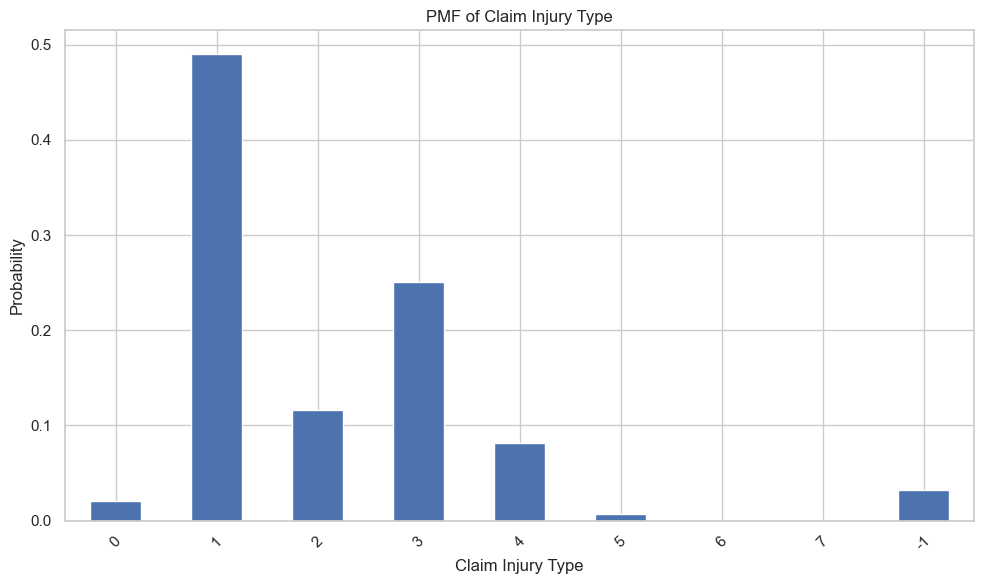

Claim Injury Type
1. CANCELLED       0.021024
2. NON-COMP        0.490467
3. MED ONLY        0.116107
4. TEMPORARY       0.250235
5. PPD SCH LOSS    0.081352
6. PPD NSL         0.007096
7. PTD             0.000163
8. DEATH           0.000792
Missing            0.032765
Name: count, dtype: float64


In [6]:
# Compute the probability mass function


# Calculate probabilities
probabilities = counts / counts.sum()

# Define the mapping
injury_type_mapping = {
    '1. CANCELLED': 0,
    '2. NON-COMP': 1,
    '3. MED ONLY': 2,
    '4. TEMPORARY': 3,
    '5. PPD SCH LOSS': 4,
    '6. PPD NSL': 5,
    '7. PTD': 6,
    '8. DEATH': 7,
    'Missing': -1  # Represent missing values as -1
}

# Apply the mapping
copy_train_df['Claim Injury Type Numeric'] = copy_train_df['Claim Injury Type'].map(injury_type_mapping)

# Generate labels
labels = [injury_type_mapping.get(x, str(x)) for x in probabilities.index]

# Print labels
print("Labels List:", labels)

# Plot the PMF
plt.figure(figsize=(10, 6))
probabilities.plot(kind='bar')

plt.xlabel('Claim Injury Type')
plt.ylabel('Probability')
plt.title('PMF of Claim Injury Type')


# Set ticks and labels
plt.xticks(ticks=range(len(probabilities)), labels=labels, rotation=45)
plt.tight_layout()
plt.show()

""" print("Counts Index:", counts.index.tolist())
print("Probabilities Index:", probabilities.index.tolist()) """
print(probabilities)

In [7]:
# Calculating skewness and kurtosis

skewness = copy_train_df['Claim Injury Type Numeric'].skew() # Slight positive skew 
print(f"Skewness: {skewness:.2f}") # The majority of the claims are concentrated around the lower injury types, with fewer claims in the 
# higher severity categories.

kurtosis = copy_train_df['Claim Injury Type Numeric'].kurtosis() #The distribution of claim injury types is less peaked and has lighter tails compared 
# to a normal distribution. The data is more evenly spread out, with fewer extreme outliers

print(f"Kurtosis: {kurtosis:.2f}")

Skewness: 0.29
Kurtosis: -0.22


Examine Missing Values

In [8]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

missing_values = missing_values_table(copy_train_df)

Your selected dataframe has 34 columns.
There are 30 columns that have missing values.


In [9]:
missing_values.head(30)

,Missing Values,% of Total Values
OIICS Nature of Injury Description,593471,100.0
IME-4 Count,460668,77.6
First Hearing Date,442673,74.6
C-3 Date,406226,68.4
Birth Year,48523,8.2
Average Weekly Wage,48096,8.1
Zip Code,48082,8.1
WCIO Part Of Body Description,36527,6.2
WCIO Part Of Body Code,36527,6.2
WCIO Nature of Injury Description,35102,5.9


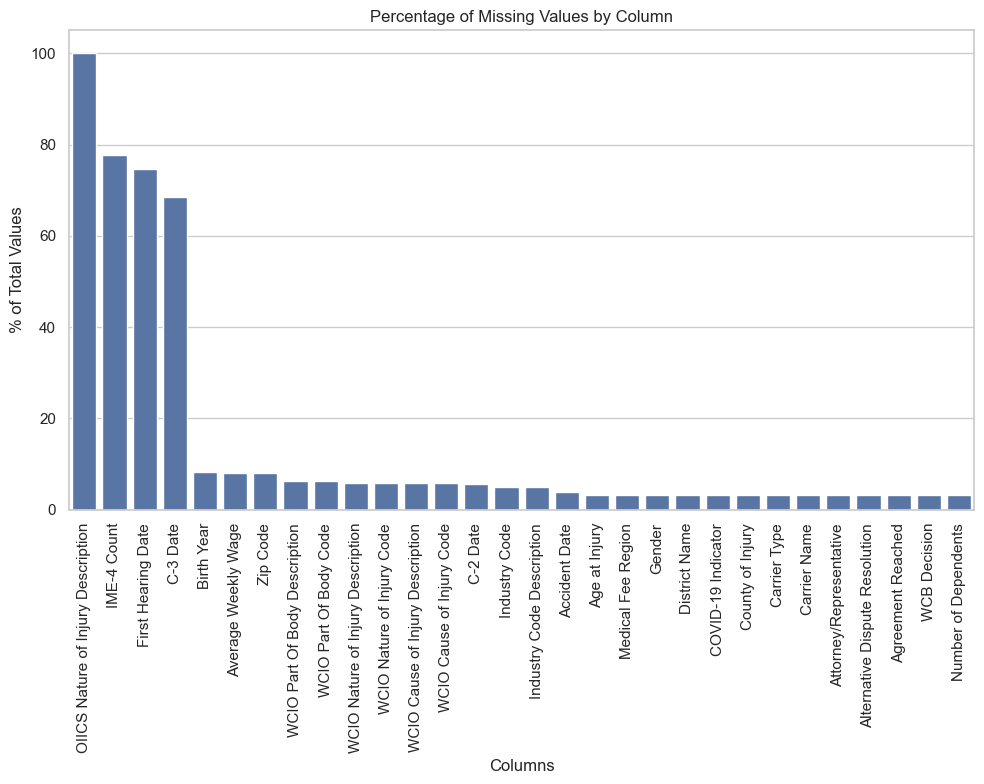

In [10]:
# Assuming mis_val_table_ren_columns is your resulting table
def plot_missing_values(mis_val_table):
    plt.figure(figsize=(10, 8))
    
    # Create a bar plot for the percentage of missing values
    sns.barplot(x=mis_val_table.index, 
                y=mis_val_table['% of Total Values'])
    
    # Rotate the x labels for better readability
    plt.xticks(rotation=90)
    
    # Set plot labels and title
    plt.title('Percentage of Missing Values by Column')
    plt.xlabel('Columns')
    plt.ylabel('% of Total Values')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Call the function to plot the missing values
plot_missing_values(missing_values)

### Numerical and categorical features split

In [12]:
# Separate from X_copy numerical and categorical columns
numerical_cols = copy_train_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = copy_train_df.select_dtypes('object').columns.tolist()

print(numerical_cols, "\n", categorical_cols)

['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'Claim Identifier', 'IME-4 Count', 'Industry Code', 'OIICS Nature of Injury Description', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Agreement Reached', 'Number of Dependents', 'Claim Injury Type Numeric'] 
 ['Accident Date', 'Alternative Dispute Resolution', 'Assembly Date', 'Attorney/Representative', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type', 'Claim Injury Type', 'County of Injury', 'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender', 'Industry Code Description', 'Medical Fee Region', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code', 'WCB Decision']


### Anomalies detection on numerical features

In [26]:
def numerical_describe(df, num_col):
    # Check if the column in the DataFrame is numerical
    if np.issubdtype(df[num_col].dtype, np.number):
        return df[num_col].describe()
    else:
        return None

# Iterate over the list of numerical columns
for col in numerical_cols:
    print(f"Description for column {col}:\n")
    
    print(numerical_describe(copy_train_df, col))



Description for column Age at Injury:

count    574026.000000
mean         42.114270
std          14.256432
min           0.000000
25%          31.000000
50%          42.000000
75%          54.000000
max         117.000000
Name: Age at Injury, dtype: float64
Description for column Average Weekly Wage:

count    5.453750e+05
mean     4.910883e+02
std      6.092918e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.410000e+02
max      2.828079e+06
Name: Average Weekly Wage, dtype: float64
Description for column Birth Year:

count    544948.000000
mean       1886.767604
std         414.644423
min           0.000000
25%        1965.000000
50%        1977.000000
75%        1989.000000
max        2018.000000
Name: Birth Year, dtype: float64
Description for column Claim Identifier:

count    5.934710e+05
mean     2.366760e+07
std      1.079271e+08
min      5.393066e+06
25%      5.593414e+06
50%      5.791212e+06
75%      5.991000e+06
max      9.998917e+08
Name: C

Text(0.5, 0, 'Age at Injury')

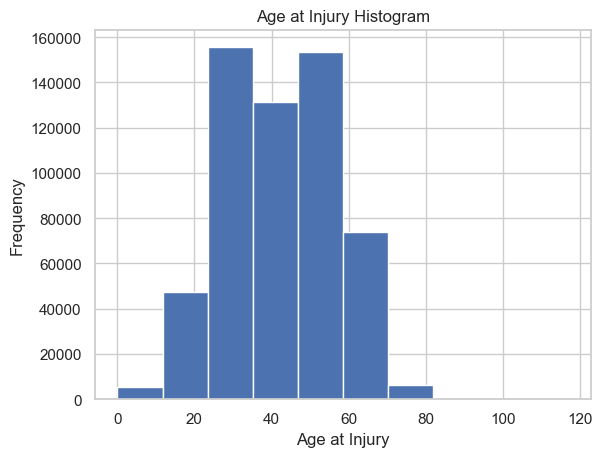

In [19]:
# Age at injury has a max value of 117, which is likely an error

copy_train_df['Age at Injury'].plot.hist(title = 'Age at Injury Histogram');
plt.xlabel('Age at Injury')

There are 0 persons with anomalous age of injury.


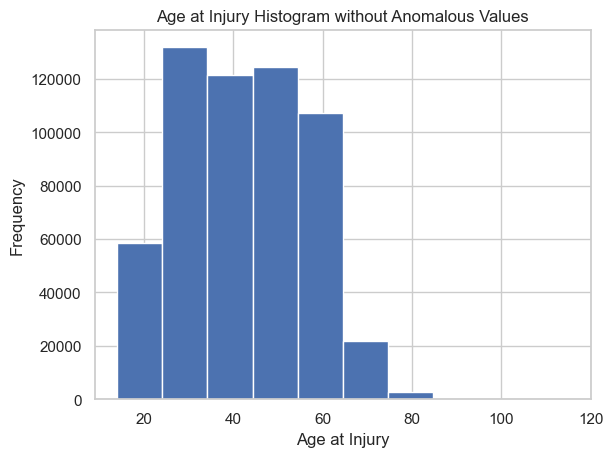

In [42]:
# Anomalous ages: 117 or under 14 (minimum legal working age in the US)
anom_age = copy_train_df[(copy_train_df['Age at Injury'] == 117) | (copy_train_df['Age at Injury'] < 14)]
non_anom_age = copy_train_df[(copy_train_df['Age at Injury'] != 117) & (copy_train_df['Age at Injury'] >= 14)]

print(f'There are {len(anom_age)} persons with anomalous age of injury.')

# Create an anomalous age flag column: True if age is anomalous, otherwise False
copy_train_df['ANOM_AGE'] = (copy_train_df['Age at Injury'] == 117) | (copy_train_df['Age at Injury'] < 14)

# Replace the anomalous age values (117 or age under 14) with NaN
copy_train_df.loc[copy_train_df['ANOM_AGE'], 'Age at Injury'] = np.nan

# Plot the 'Age at Injury' histogram (after replacing anomalous values)
copy_train_df['Age at Injury'].plot.hist(title='Age at Injury Histogram without Anomalous Values')
plt.xlabel('Age at Injury')
plt.show()


In [40]:
anom_wage = copy_train_df[copy_train_df['Average Weekly Wage'] > 2000000]
non_anom_wage = copy_train_df[copy_train_df['Average Weekly Wage'] != 2000000]

print(f'There are {len(anom_wage)} persons with anomalous average weekly wage.')

There are 2 persons with anomalous average weekly wage.


### Column Types
Let's look at the number of columns of each data type. int64 and float64 are numeric variables (which can be either discrete or continuous). object columns contain strings and are categorical features. .

In [11]:
copy_train_df.dtypes.value_counts()

object     21
float64    11
int64       2
Name: count, dtype: int64

Let's now look at the number of unique entries in each of the object (categorical) columns.

In [14]:
copy_train_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0) # axis = 0 to apply function to each column

Accident Date                         5539
Alternative Dispute Resolution           3
Assembly Date                         1096
Attorney/Representative                  2
C-2 Date                              2475
C-3 Date                              1648
Carrier Name                          2046
Carrier Type                             8
Claim Injury Type                        9
County of Injury                        63
COVID-19 Indicator                       2
District Name                            8
First Hearing Date                    1094
Gender                                   4
Industry Code Description               20
Medical Fee Region                       5
WCIO Cause of Injury Description        74
WCIO Nature of Injury Description       56
WCIO Part Of Body Description           54
Zip Code                             10060
WCB Decision                             1
dtype: int64

Most of the categorical variables have a relatively small number of unique entries. We will need to find a way to deal with these categorical variables.

In [4]:
""" # List of variables you want to assess correlation with
variables = ['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
             'Assembly Date' ,'Attorney/Representative' , 'Average Weekly Wage',
             'C-2 Date' , 'C-3 Date' , 'Carrier Name' , 'Carrier Type',
             'COVID-19 Indicator', 'District Name' , 'First Hearing Date',
             'Gender' , 'IME-4 Count' , 'Industry Code' , 'Medical Fee Region',
             'WCIO Cause of Injury Code' , 'Zip Code',
             'Agreement Reached' ,'Number of Dependents'
             ]  # Replace with your actual variable names


# Assuming your target variable is 'Claim Injury Type'
target_column = 'Claim Injury Type'

# Empty list to store the results
correlation_results = []

# Assuming your target variable is 'Claim Injury Type'
target_column = 'Claim Injury Type'

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Empty list to store the results
correlation_results = []

# Loop through the variables
for var in variables:
    # Drop rows with NaN values in the current variable and target
    train_df_clean = train_df[[var, target_column]].dropna()

    # Check if both the variable and the target column are numeric
    if pd.api.types.is_numeric_dtype(train_df_clean[var]) and pd.api.types.is_numeric_dtype(train_df_clean[target_column]):
        # Calculate Pearson correlation (only for numeric data)
        pearson_corr, _ = pearsonr(train_df_clean[var], train_df_clean[target_column])
    else:
        pearson_corr = 'Non-numeric'

    # Convert all values to strings for Label Encoding
    train_df_clean[var] = train_df_clean[var].astype(str)
    train_df_clean[target_column] = train_df_clean[target_column].astype(str)

    # Encode non-numeric data for Spearman correlation
    train_df_clean[var] = label_encoder.fit_transform(train_df_clean[var])
    train_df_clean[target_column] = label_encoder.fit_transform(train_df_clean[target_column])
    
    # Calculate Spearman correlation
    spearman_corr, _ = spearmanr(train_df_clean[var], train_df_clean[target_column])
    
    # Append the results to the list
    correlation_results.append({
        'Variable': var,
        'Pearson Correlation': pearson_corr,
        'Spearman Correlation': spearman_corr
    })

# Convert results to a DataFrame for easier reading
correlation_df = pd.DataFrame(correlation_results)

correlation_df.head(21)
 """

" # List of variables you want to assess correlation with\nvariables = ['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',\n             'Assembly Date' ,'Attorney/Representative' , 'Average Weekly Wage',\n             'C-2 Date' , 'C-3 Date' , 'Carrier Name' , 'Carrier Type',\n             'COVID-19 Indicator', 'District Name' , 'First Hearing Date',\n             'Gender' , 'IME-4 Count' , 'Industry Code' , 'Medical Fee Region',\n             'WCIO Cause of Injury Code' , 'Zip Code',\n             'Agreement Reached' ,'Number of Dependents'\n             ]  # Replace with your actual variable names\n\n\n# Assuming your target variable is 'Claim Injury Type'\ntarget_column = 'Claim Injury Type'\n\n# Empty list to store the results\ncorrelation_results = []\n\n# Assuming your target variable is 'Claim Injury Type'\ntarget_column = 'Claim Injury Type'\n\n# Initialize LabelEncoder\nlabel_encoder = LabelEncoder()\n\n# Empty list to store the results\ncorrelation_results =

_"Explore data visually and extract relevant insights. Explain your rationale and
findings. Do not forget to analyse multivariate relationships."_

## 3. Data Cleaning and Pre-processing <a id='dataclean'></a>
[to the top](#top)

- _"Are there any missing values? Take action to handle them._
- _Check the dataset for outliers and pre-process them. Justify your decisions._
- _Deal with categorical variables._
- _Review current features and create extra features if needed. Explain your steps._
- _Perform data scaling. Explain the reasoning behind your choices."_

## 4. Feature Selection <a id='features'></a>
[to the top](#top)

_"Define and implement an unambiguous strategy for feature selection. Use methods discussed in the course. Present and justify your final selection."_

## 5. Modeling and Evaluation <a id='modeling'></a>
[to the top](#top)

- _"Identify the type of the problem and select the relevant algorithms._
- _Use cross-validation to assess performance. Which metrics did you use and why?_
- _Train at least 1 model using the train dataset and obtain predictions for the test dataset."_

In [5]:
# test